## install dependencies

In [135]:
from scipy.io import loadmat
import mat73
import matplotlib.pyplot as plt
from hmmlearn import hmm
import numpy as np
from tqdm import notebook
from scipy import stats
from scipy.signal import hilbert
from scipy.signal import butter, sosfiltfilt
from scipy import signal
from scipy.fft import fftshift
from kneed import KneeLocator
import pickle
import joblib

## define bandpower func

In [136]:
def bandpower(data, fs, band, method, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper

    band = np.asarray(band)
    low, high = band

    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * fs
        else:
            nperseg = (2 / low) * fs

        freqs, psd = welch(data, fs, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, fs, adaptive=True,
                                          normalization='full', 
                                          verbose=0)
    else:
        print('Method not implemented.')

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

## load lfp (mat 7.3) file

In [137]:
filepath = '../processed_data/lfp.mat'

In [138]:
ey_lfp = mat73.loadmat(filepath)

In [139]:
fs = int(ey_lfp["lfp"]["samplerate"][0])
print(f'sampling frequency is {fs} Hz')

sampling frequency is 1250 Hz


In [140]:
full_lfp = np.vstack([ey_lfp['lfp']['data'][ch] for ch in range(len(ey_lfp['lfp']['data']))]).T
print(f'full LFP lasted for {full_lfp.shape[0]/(fs*60*60)} hours across {full_lfp.shape[1]} channels')

full LFP lasted for 4.540507555555555 hours across 39 channels


In [141]:
full_lfp.shape

(20432284, 39)

## Bandpass + Hilbert

In [142]:
# define frequency ranges for band powers
freq_bands = [[3, 8], [10, 30], [30, 50], [50, 80]]
bands = ['theta', 'beta', 'lower_gamma', 'higher_gamma']
# initialize list
band_pow = []

# define window in seconds for frequency analysis
window_dur = 1
# define time total in hours for analysis
duration_total = 1

# for each band
for i, freq_band in enumerate(notebook.tqdm(freq_bands)):
    sos = butter(14, freq_band, 'bandpass', output='sos', fs=1250) # 14-order bandpass butterworth filter
    instant_band_pow_all = []
    # for each channel
    for ch in notebook.tqdm(range(full_lfp.shape[1])):
        # bandpass lfp
        filt_lfp = sosfiltfilt(sos, full_lfp[:duration_total*60*60*fs:int(fs/250), ch])
        # filt_lfp = sosfiltfilt(sos, full_lfp[:duration_total*60*60*fs, ch])
        # get analytic signal by Hilbert transform
        amp_envelope_lfp = np.abs(hilbert(filt_lfp))
        # a list of 39 channels, single band power
        instant_band_pow_all.append(amp_envelope_lfp)
    band_pow.append(instant_band_pow_all)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

In [143]:
lpf_features = np.vstack(([np.vstack(band_pow[b]) for b in range(len(band_pow))]))
lpf_features.T.shape
# it'll print samples x (channels x num bands)

(900000, 156)

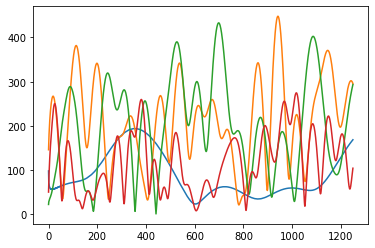

In [144]:
for n in range(4):
    plt.plot(lpf_features[full_lfp.shape[1]*n, :fs])

## Select number of hmm states using rf

In [164]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def rf_f1_score(hmm_model, lpf_features, spikes, limit_count=100, verbose=False):
    Z2 = hmm_model.predict(lpf_features)
    X = spikes.copy()
    # y = []
    # stride = int(lpf_features.shape[0]/spikes.shape[0])
    # for c_ind in range(spikes.shape[0]):
    #     if c_ind == 0:
    #         states, cnts = np.unique(Z2[:(int(stride/2)+1)], return_counts=True)
    #         y.append(states[np.argmax(cnts)])
    #     elif c_ind == spikes.shape[0]-1:
    #         states, cnts = np.unique(Z2[-(int(stride/2)+1):], return_counts=True)
    #         y.append(states[np.argmax(cnts)])
    #     else:
    #         states, cnts = np.unique(Z2[c_ind*stride-int(stride/2):c_ind*stride+int(stride/2)], return_counts=True)
    #         y.append(states[np.argmax(cnts)])
    # y = np.array(y)
    y = Z2[::int(lpf_features.shape[0]/spikes.shape[0])]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if verbose:
        print(X.shape, y.shape, [len(np.where(y == s)[0]) for s in np.unique(Z2)])
    np.random.seed(2022)
    y_subsampled = []
    X_subsampled = []
    for s in np.unique(Z2):
        idx_s = np.where(y==s)[0]
        try:
            sampled_idx_s = np.random.choice(len(idx_s), limit_count, replace=False)
        except:
            sampled_idx_s = np.random.choice(len(idx_s), len(idx_s), replace=False)
        y_subsampled.append(y[idx_s[sampled_idx_s]])
        X_subsampled.append(X[idx_s[sampled_idx_s], :])
    if verbose:
        print(np.hstack(y_subsampled).shape, np.vstack(X_subsampled).shape)
    X_train, X_test, y_train, y_test = train_test_split(np.vstack(X_subsampled), np.hstack(y_subsampled), 
                                                        test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)

    return f1_score(y_test, predict, average="macro")

In [165]:
filename = '../processed_data/m1_fr0.1hz_30hz_0s_7200s_0.1s_bins_nooverlap.sav'

with open(filename, 'rb') as file:
    spike_times_all_neurons = joblib.load(file)

# Convert to numpy array
spike_times_all_neurons = np.array(spike_times_all_neurons)

# Transpose into (71999, 90)
spike_times_all_neurons = spike_times_all_neurons.T

# Truncate two hour m1 recording to one hour l5 recording into (36000, 46), 
# 0th to 45th L5/6, 46th to 89th L2/3, 89th being the most shallow
spike_times_l5_neurons_1h = spike_times_all_neurons[:36000, :46]

# # (Number of 100-ms bins, Number of l2 neurons)
# T_1h, D_m1 = spike_times_all_neurons_1h.shape

# Z-score each neuron, i.e. firing rates of each neuron across time sum to 0
spike_times_l5_neurons_1h_zscored = stats.zscore(spike_times_l5_neurons_1h) # Default axis is 0

spikes = spike_times_l5_neurons_1h_zscored
print(f'Spike times are binned into shape for hmm: {spikes.shape}')

Spike times are binned into shape for hmm: (36000, 46)


  0%|          | 0/10 [00:00<?, ?it/s]

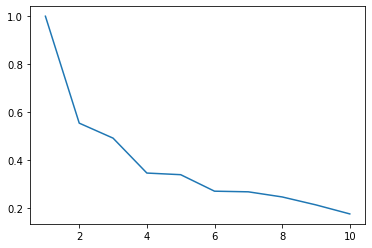

In [166]:
f1_score_arr = []
for K in notebook.tqdm(range(1, 11)):
    hmm_curr = pickle.load(open(f'../hmm_models/hmm_hilbert/hmm_lpf_{K}_states.hmm', 'rb'))
    f1_score_arr.append(rf_f1_score(hmm_curr, lpf_features.T, spikes, limit_count=1250, verbose=False))
plt.plot(range(1, 11), f1_score_arr)

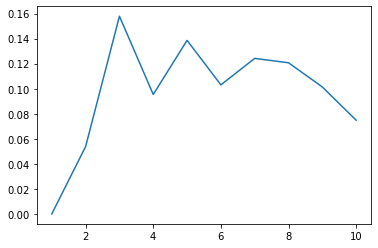

In [167]:
plt.plot(range(1, 11), f1_score_arr - np.array([1/K for K in range(1, 11)]))

## Classify behaviors within hmm states

In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def rf_f1_score(data, targets, limit_count=100, verbose=False):
    X = data.copy()
    y = targets.copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    if verbose:
        print(X.shape, y.shape, [len(np.where(y == s)[0]) for s in np.unique(Z2)])
    np.random.seed(2022)
    y_subsampled = []
    X_subsampled = []
    for s in np.unique(y):
        idx_s = np.where(y==s)[0]
        try:
            sampled_idx_s = np.random.choice(len(idx_s), limit_count, replace=False)
        except:
            sampled_idx_s = np.random.choice(len(idx_s), len(idx_s), replace=False)
        y_subsampled.append(y[idx_s[sampled_idx_s]])
        X_subsampled.append(X[idx_s[sampled_idx_s], :])
    if verbose:
        print(np.hstack(y_subsampled).shape, np.vstack(X_subsampled).shape)
    X_train, X_test, y_train, y_test = train_test_split(np.vstack(X_subsampled), np.hstack(y_subsampled), 
                                                        test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)

    return f1_score(y_test, predict, average="macro")

In [174]:
import os
import sys
sys.path.append('../libraries/') # Append the path within which the user-defined class is in
from data_loader import data_loader
from behavior_loader import bsoid_loader

In [175]:
data_dir = r'../processed_data'
file_name = r'ag25290_day2_iter13'
# Load behaviors
behavior_loader = bsoid_loader(data_dir, file_name)
f_index, filtered_data, smoothed_predictions = behavior_loader.main()

mouse stayed in nest for 0.28108749470484795% of time
File #0 (a 6 body parts by 984391 frames) has 30 classes


In [179]:
# Correct prediction start
framerate = 60
delay = 6.8503
behavior_start = int(delay * framerate)  # start of behavior
smoothed_predictions_1h = smoothed_predictions[behavior_start:(behavior_start+3600*60):int(60/10)]

In [180]:
smoothed_predictions_1h.shape

(36000,)

In [189]:
K = 3
hmm_best = pickle.load(open(f'../hmm_models/hmm_hilbert/hmm_lpf_{K}_states.hmm', 'rb'))
hmm_states = hmm_best.predict(lpf_features.T)[::int(lpf_features.T.shape[0]/spikes.shape[0])]
f1_score_behav = rf_f1_score(spikes, smoothed_predictions_1h, limit_count=100, verbose=False)
f1_score_sep_behav = []
for hmm_state in notebook.tqdm(np.unique(hmm_states)):
    idx_ = np.where(hmm_states == hmm_state)[0]
    spikes_state = spikes[idx_, :]
    smoothed_predictions_1h_state = smoothed_predictions_1h[idx_]
    f1_score_sep_behav.append(rf_f1_score(spikes_state, smoothed_predictions_1h_state, limit_count=100, verbose=False))

  0%|          | 0/3 [00:00<?, ?it/s]

In [186]:
f1_score_behav

0.27679777473321004

In [190]:
f1_score_sep_behav

[0.24800336184033184, 0.30232892759304825, 0.25883607017440546]

In [191]:
np.mean(f1_score_sep_behav)

0.2697227865359285

## visualize 1:1 mapping

In [168]:
lpf_features.shape

(156, 900000)

In [169]:
hmm_best = pickle.load(open(f'../hmm_models/hmm_hilbert/hmm_lpf_3_states.hmm', 'rb'))
Z2 = hmm_best.predict(lpf_features.T)
for hmm_state in np.unique(Z2):
    

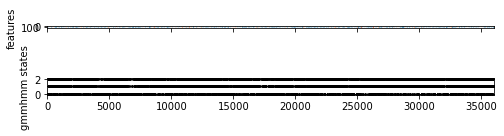

In [170]:
fig, ax = plt.subplots(2, 1, figsize=(8, 2), gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
im = ax[0].imshow(lpf_features[:, ::25], vmin=-3, vmax=300, cmap='RdBu_r')

ax[1].scatter(np.arange(len(Z2[::25])), Z2[::25], s=0.3, color='k')
ax[0].set_ylabel('features')
ax[1].set_ylabel('gmmhmm states')

# ax[1].set_xticks(np.arange(0, len(Z2), 180))
# ax[1].set_xticklabels(np.arange(0, 3, 0.5))
# ax[1].set_xlabel('Time (hrs)')
plt.show()
# fig.savefig('./lfp_hmm.png', dpi=300)

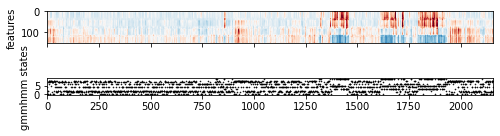

In [244]:
fig, ax = plt.subplots(2, 1, figsize=(8, 2), gridspec_kw={'height_ratios': [5, 1]}, sharex=True)
im = ax[0].imshow(lpf_features[:, ::25], vmin=-3, vmax=3, cmap='RdBu_r')

ax[1].scatter(np.arange(len(Z2[::25])), Z2[::25], s=0.3, color='k')
ax[0].set_ylabel('features')
ax[1].set_ylabel('gmmhmm states')

# ax[1].set_xticks(np.arange(0, len(Z2), 180))
# ax[1].set_xticklabels(np.arange(0, 3, 0.5))
# ax[1].set_xlabel('Time (hrs)')
plt.show()
# fig.savefig('./lfp_hmm.png', dpi=300)


In [99]:
hmm_best = pickle.load(open(f'../hmm_models/hmm_hilbert/hmm_lpf_3_states.hmm', 'rb'))
Z2 = hmm_best.predict(lpf_features.T)

In [100]:
Z2.shape

(900000,)

In [101]:
np.unique(Z2)

array([0, 1, 2])

In [120]:
np.min(lpf_features)
np.max(lpf_features)

1599.383064183868

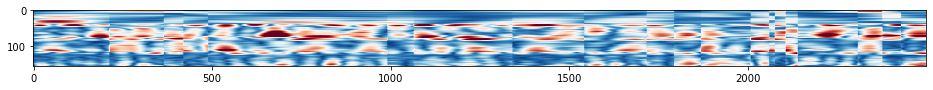

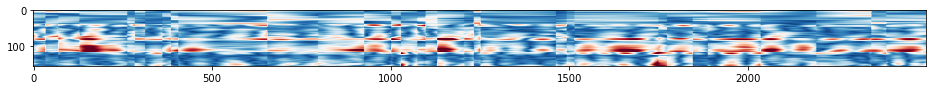

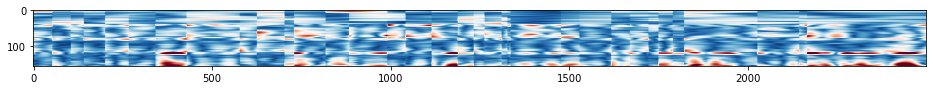

In [171]:
# fig, ax = plt.subplots(1, 1, figsize=(5, 10), gridspec_kw={'height_ratios': [10, 1]}, sharex=True)
rows = len(np.unique(Z2))
cols = 1
# fig, ax = plt.subplots(rows, cols, figsize=(20, 16), sharex=True, sharey=True)
# for hmm_state in np.arange(len(np.unique(Z2))):
for hmm_state in np.unique(Z2):
    fig, ax = plt.subplots(1, 1, figsize=(16, 11), sharex=True, sharey=True)
    idx_ = np.where(Z2==hmm_state)[0]
#     ax.plot(features[0, idx_])
    ax.imshow(lpf_features[:, idx_[:2500]], vmin=0, vmax=400, cmap='RdBu_r')